In [1]:
import os 
os.chdir('../')
import torch
import torchvision 
import random 
import torch.nn as nn
import numpy as np 
import matplotlib.pyplot as plt 

from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms

In [2]:
!pwd 

/home/gosh/Desktop/Search_Engine_Img2Img/Benchmark


In [3]:
data_path = "Dataset Selection/Images_frankwebb"
print("Dataset exists." if os.path.exists(data_path) else "Dataset does not exist!")

transform = transforms.Compose([
    transforms.Resize((380, 380)),  # Resize every image to 380x380
    transforms.ToTensor(),
])

dataset = datasets.ImageFolder(data_path, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

Dataset exists.


Min pixel value: 0.0
Max pixel value: 1.0
Unique labels [0 1 2 3]
Image shapes torch.Size([32, 3, 380, 380])


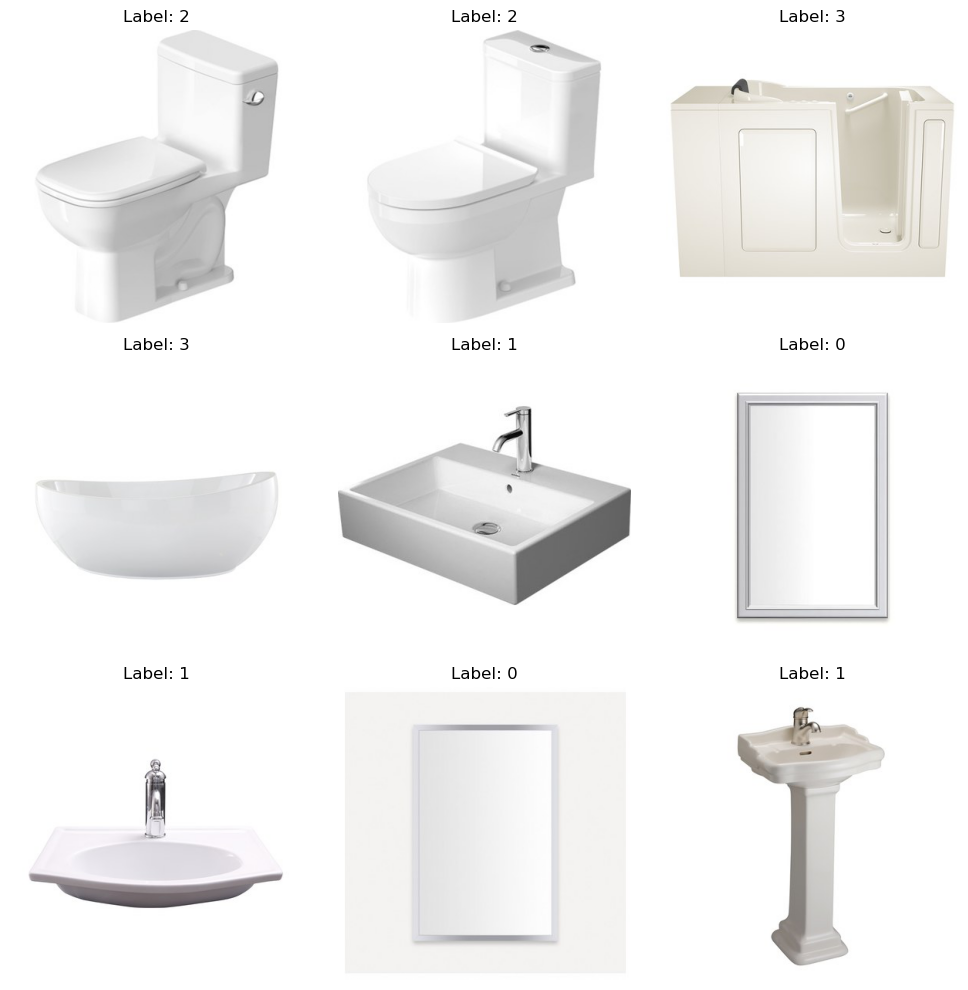

In [4]:
data_iter = iter(dataloader)
images, labels = next(data_iter)

print(f"Min pixel value: {images.min().item()}")  
print(f"Max pixel value: {images.max().item()}")  
print(f"Unique labels {np.unique(labels)}")
print(f"Image shapes {images.shape}")

batch_size = images[:9].size(0)
ncols = 3
nrows = (batch_size + ncols - 1) // ncols

fig, axes = plt.subplots(nrows, ncols, figsize=(10, 10))
axes = axes.flatten()

for i in range(batch_size):
    img = images[i].permute(1, 2, 0).cpu().numpy()  
    axes[i].imshow(img)
    axes[i].set_title(f"Label: {labels[i].item()}")
    axes[i].axis('off')

for j in range(batch_size, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


In [5]:
class SiameseDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        
        self.image_paths = []
        self.labels = []
        for label in os.listdir(root_dir):
            class_path = os.path.join(root_dir, label)
            if os.path.isdir(class_path):
                for file_name in os.listdir(class_path):
                    if file_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                        self.image_paths.append(os.path.join(class_path, file_name))
                        self.labels.append(label)
        
        self.label_to_indices = {}
        for index, label in enumerate(self.labels):
            if label not in self.label_to_indices:
                self.label_to_indices[label] = []
            self.label_to_indices[label].append(index)

    def __getitem__(self, index):
        img1_path = self.image_paths[index]
        img1 = Image.open(img1_path).convert("RGB")
        label1 = self.labels[index]
        
        if self.transform:
            img1 = self.transform(img1)
        
        should_get_same_class = random.randint(0, 1)
        if should_get_same_class:
            idx2 = index
            while idx2 == index:
                idx2 = random.choice(self.label_to_indices[label1])
        else:
            different_labels = list(set(self.labels) - {label1})
            label2 = random.choice(different_labels)
            idx2 = random.choice(self.label_to_indices[label2])
        
        img2_path = self.image_paths[idx2]
        img2 = Image.open(img2_path).convert("RGB")
        if self.transform:
            img2 = self.transform(img2)
        
        label = 1 if should_get_same_class else 0
        
        return img1, img2, label

    def __len__(self):
        return len(self.image_paths)

In [6]:
transform = transforms.Compose([
    transforms.Resize((380, 380)),
    transforms.ToTensor(),
])

siamese_dataset = SiameseDataset(root_dir=data_path, transform=transform)

dataloader = DataLoader(siamese_dataset, batch_size=32, shuffle=True)


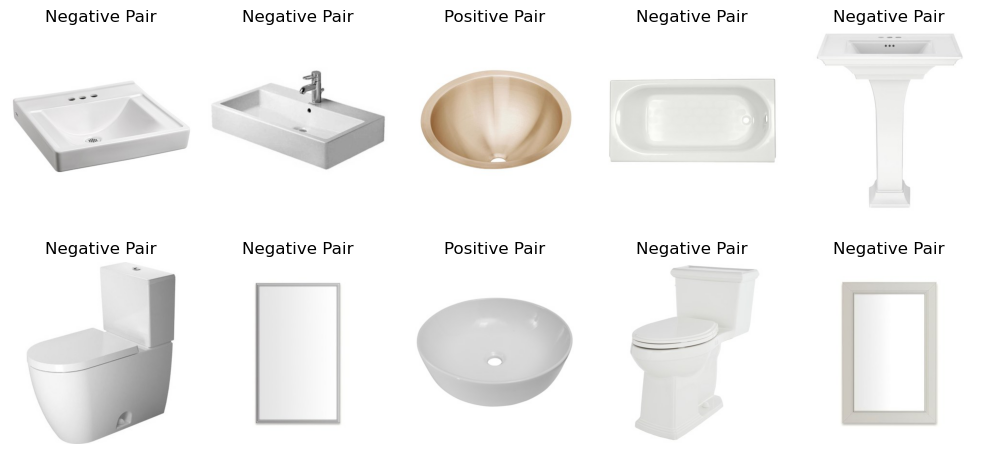

In [7]:
img1, img2, labels = next(iter(dataloader))

num_pairs = img1[:5].size(0)
fig, axes = plt.subplots(2,num_pairs, figsize=(10, num_pairs))

if num_pairs == 1:
    axes = axes.reshape(1, -1)

for i in range(num_pairs):
    img1_np = img1[i].permute(1, 2, 0).cpu().numpy()
    img2_np = img2[i].permute(1, 2, 0).cpu().numpy()
    
    title_text = 'Positive Pair' if labels[i].item() == 1 else 'Negative Pair'
    
    axes[0, i].imshow(img1_np)
    axes[0, i].set_title(title_text)
    axes[0, i].axis('off')
    
    axes[1, i].imshow(img2_np)
    axes[1, i].set_title(title_text)
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

In [8]:
class SNN(nn.Module):
    def __init__(self):
        super(SNN, self).__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        # For a 380x380 image with two 2x2 pooling operations, the output spatial dims become 95x95.
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32 * 95 * 95, 128),
            nn.ReLU(),
        )
    
    def forward(self, x, y):
        embd_1 = self.fc(self.feature_extractor(x))
        embd_2 = self.fc(self.feature_extractor(y))
        return embd_1, embd_2
siamese_model = SNN()

In [9]:
data_iter = iter(dataloader)
image_1, image_2, labels = next(data_iter)

params = {
    "Min pixel value": images.min().item(),
    "Max pixel value": images.max().item(),
    "Mean pixel value": images.mean().item(),
    "Std deviation": images.std().item(),
    "Image shape": images.shape,              
    "Data type": images.dtype,
    "Unique labels": np.unique(labels.cpu().numpy()),
    "Batch size": images.shape[0],
}

for key, value in params.items():
    print(f"{key}: {value}")

Min pixel value: 0.0
Max pixel value: 1.0
Mean pixel value: 0.8953312635421753
Std deviation: 0.17961059510707855
Image shape: torch.Size([32, 3, 380, 380])
Data type: torch.float32
Unique labels: [0 1]
Batch size: 32


In [ ]:
class ContrastiveLoss(nn.Module):
    """
    Contrastive loss function based on Hadsell et al. (2006).
    """
    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = torch.norm(output1 - output2, p=2, dim=1)
        loss_similar = label.view(-1) * torch.pow(euclidean_distance, 2)
        loss_dissimilar = (1 - label.view(-1)) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2)
        loss = torch.mean(loss_similar + loss_dissimilar)
        return loss


In [11]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
optimizer = torch.optim.Adam(siamese_model.parameters(), lr=0.001)
siamese_model.to(device)
epochs = 250
criterion = ContrastiveLoss(margin=1.0)

train_loss = []

print(f"Training starts on divce ---> {device}")
for epoch in range(epochs):
    siamese_model.train()
    total_loss = 0
    for img1, img2, label in dataloader:
        img1, img2, label = img1.to(device), img2.to(device), label.to(device).view(-1, 1)

        optimizer.zero_grad()
        embd_1, embd_2 = siamese_model(img1, img2)
        loss = criterion(embd_1, embd_2, label)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_train_loss = total_loss / len(dataloader)
    train_loss.append(avg_train_loss)

    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(dataloader)}")


Training starts on divce ---> cuda
Epoch 1/250, Loss: 2.0626310928544003
Epoch 2/250, Loss: 0.2882607263415607
Epoch 3/250, Loss: 0.26407495485757715
Epoch 4/250, Loss: 0.23795032681925082
Epoch 5/250, Loss: 0.2237132019293842
Epoch 6/250, Loss: 0.26245333343299465
Epoch 7/250, Loss: 0.22511033958463528
Epoch 8/250, Loss: 0.2098369503588374
Epoch 9/250, Loss: 0.18264878963801398
Epoch 10/250, Loss: 0.1534813803189726
Epoch 11/250, Loss: 0.16161930827952142
Epoch 12/250, Loss: 0.14979752158718324
Epoch 13/250, Loss: 0.14136332734974463
Epoch 14/250, Loss: 0.13449411438917047
Epoch 15/250, Loss: 0.1319259353426855
Epoch 16/250, Loss: 0.1158526570939306
Epoch 17/250, Loss: 0.11786098267410451
Epoch 18/250, Loss: 0.12099506628157487
Epoch 19/250, Loss: 0.11826708222002681
Epoch 20/250, Loss: 0.11243458170054564
Epoch 21/250, Loss: 0.09977316809123132
Epoch 22/250, Loss: 0.09135503993011705
Epoch 23/250, Loss: 0.08529396038224447
Epoch 24/250, Loss: 0.08480907442854412
Epoch 25/250, Loss: 0

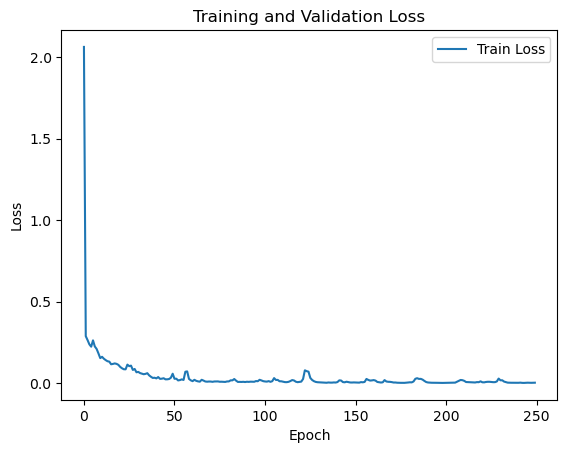

In [12]:
plt.plot(train_loss, label="Train Loss")
plt.title("Training and Validation Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(loc="upper right")
plt.show()

In [13]:
torch.save(siamese_model.state_dict(), 'siamese_model.pth')
print("Model saved to siamese_model.pth")

Model saved to siamese_model.pth


In [14]:
siamese_model_loaded = SNN()
siamese_model_loaded.load_state_dict(torch.load('siamese_model.pth', map_location=device))
siamese_model_loaded.to(device)
siamese_model_loaded.eval() 

print("Model loaded and set to evaluation mode.")

Model loaded and set to evaluation mode.


/tmp/ipykernel_77290/984830502.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  siamese_model_loaded.load_state_dict(torch.load('siamese_model.pth', map_location=device))

In [15]:
test_dataloader = DataLoader(siamese_dataset, batch_size=1, shuffle=False)

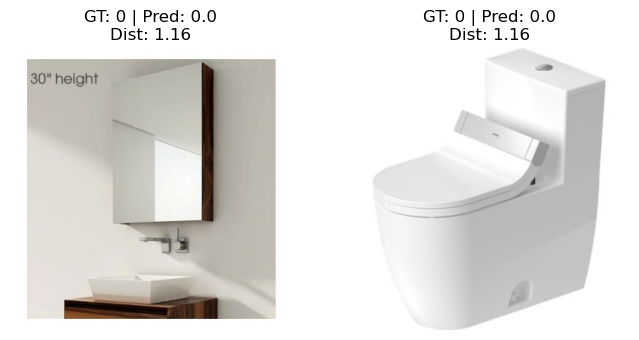

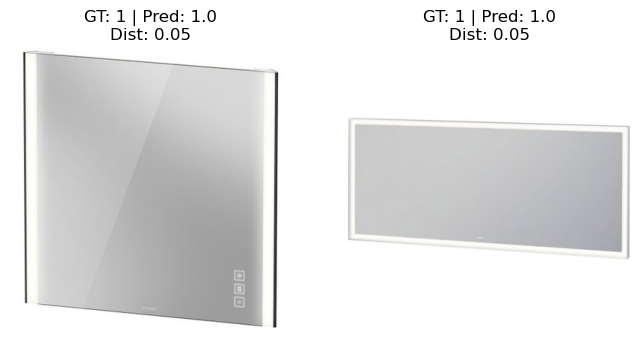

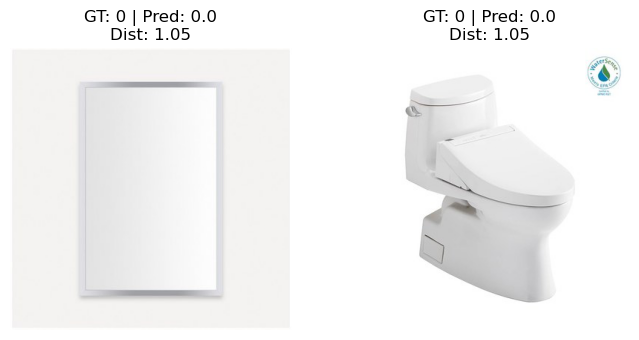

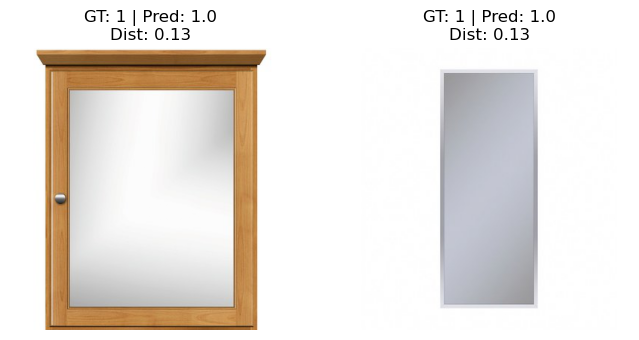

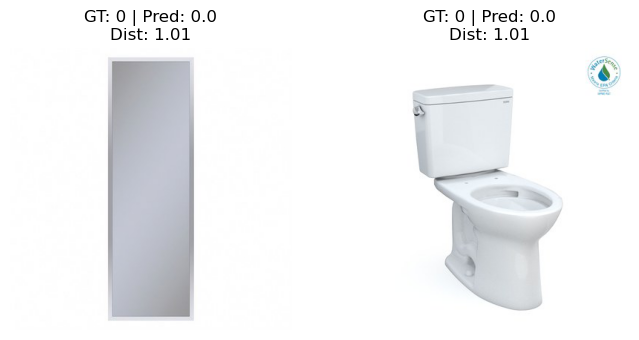

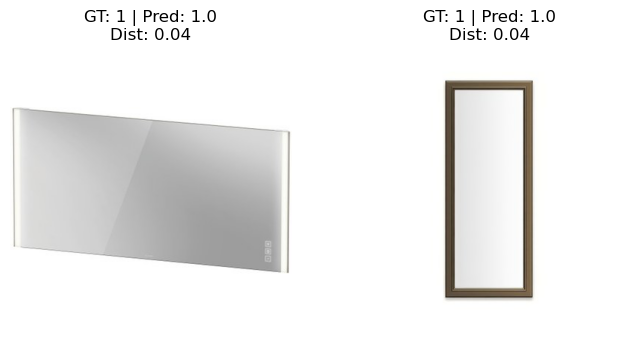

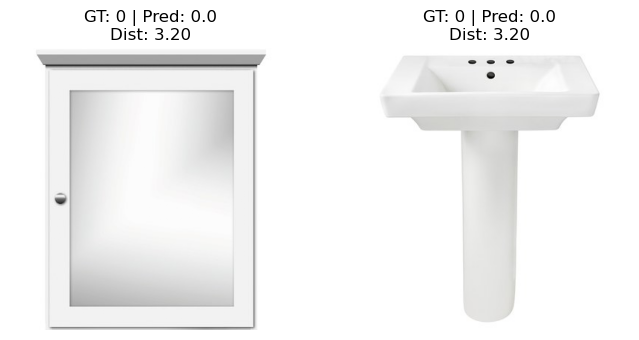

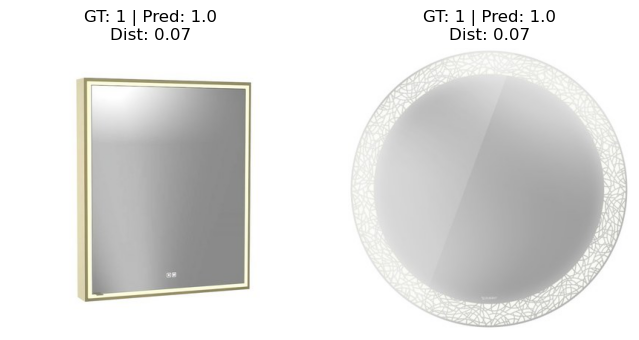

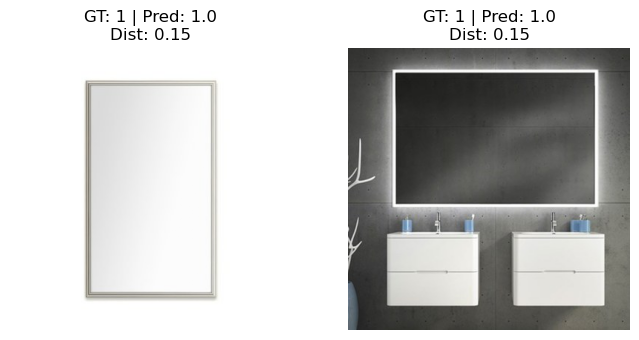

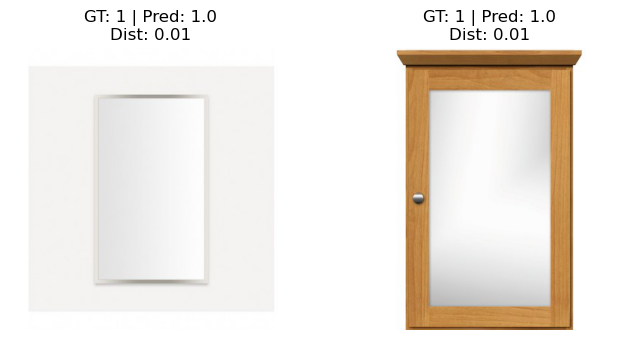

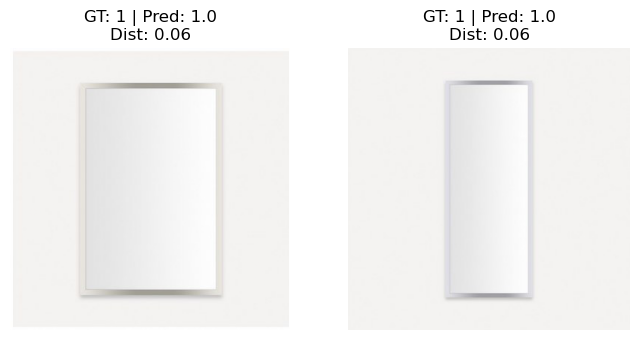

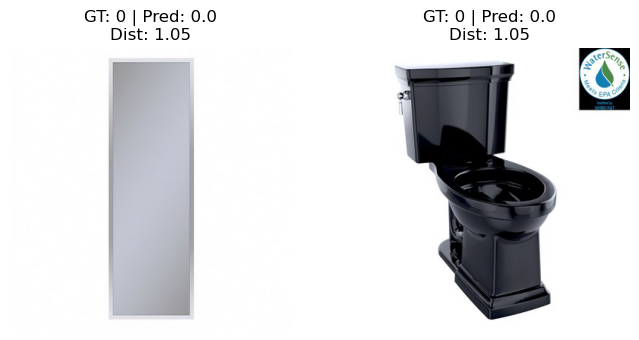

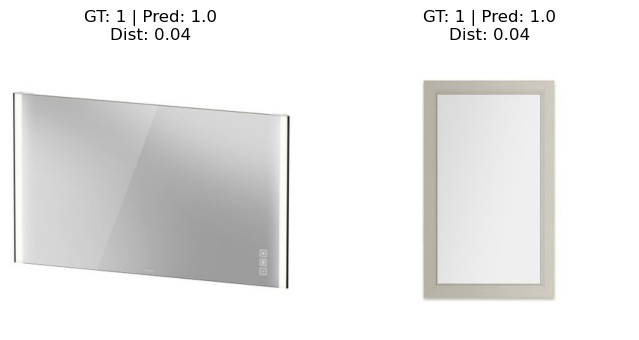

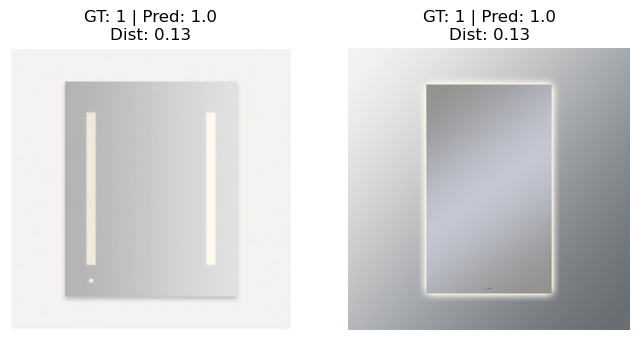

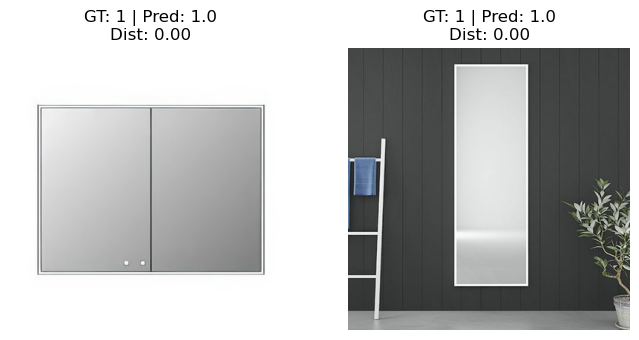

Accuracy: 100.00%


In [16]:
threshold = 1.0  

total_correct = 0
total_samples = 0

pairs_visualized = 0  # Counter for visualization


with torch.no_grad():
    for img1, img2, label in test_dataloader:
        img1, img2 = img1.to(device), img2.to(device)
        label = label.to(device).view(-1, 1)
        
        embd_1, embd_2 = siamese_model_loaded(img1, img2)
        
        distance = torch.norm(embd_1 - embd_2, p=2, dim=1, keepdim=True)
        
        predicted = (distance < threshold).float()
        
        total_correct += (predicted == label).sum().item()
        total_samples += label.size(0)
        
        if pairs_visualized < 15:
            img1_np = img1[0].permute(1, 2, 0).cpu().numpy()
            img2_np = img2[0].permute(1, 2, 0).cpu().numpy()
            
            gt_label = label[0].item()
            pred_label = predicted[0].item()
            dist_val = distance[0].item()
            
            plt.figure(figsize=(8, 4))
            
            plt.subplot(1, 2, 1)
            plt.imshow(img1_np)
            plt.title(f"GT: {gt_label} | Pred: {pred_label}\nDist: {dist_val:.2f}")
            plt.axis("off")
            
            plt.subplot(1, 2, 2)
            plt.imshow(img2_np)
            plt.title(f"GT: {gt_label} | Pred: {pred_label}\nDist: {dist_val:.2f}")
            plt.axis("off")
            
            plt.show()
            pairs_visualized += 1
        else:
            break

accuracy = total_correct / total_samples
print(f"Accuracy: {accuracy*100:.2f}%")
